In [20]:
import bart
import cfl
import matplotlib.pyplot as plt
import numpy as np
import pdb

In [21]:
# generate ground truth
fov = 20
res = 0.1
nx = fov // res
ob = bart.bart(1, 'phantom -x {} -3'.format(nx))

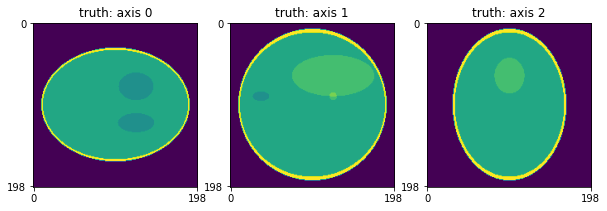

In [22]:
# view central slices
_, ax = plt.subplots(ncols=ob.ndim, figsize=(10,10))
for i in range(ob.ndim):
    slice_index = ob.shape[i] // 2
    ax[i].set_title('truth: axis {}'.format(i))
    ax[i].set_xticks([0, nx-1])
    ax[i].set_yticks([0, nx-1])
    ax[i].imshow(np.take(abs(ob), slice_index, axis=i))

In [23]:
# design trajectory
nfe = 64
npe1 = 64
traj2d = bart.bart(1, 'traj -x {} -y {}'.format(nfe, npe1))

npe2 = 64
traj = np.repeat(traj2d.reshape(3,1,nfe,npe1), npe2, axis=1)
for i in range(-npe2//2, npe2//2):
    traj[2,i,:,:] = i
    
for d in range(traj.shape[0]):
    traj[d,:,:,:] /= (res*traj.shape[d+1])
    
traj.shape = (3, nfe, npe1*npe2)

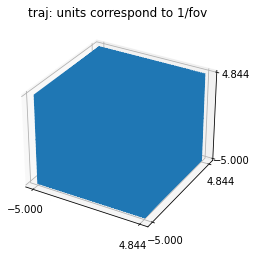

In [24]:
# plot trajectory
ax = plt.axes(projection='3d')
ax.set_xticks([-1/(2*res), (nfe/2-1)/(nfe*res)])
ax.set_yticks([-1/(2*res), (npe1/2-1)/(npe1*res)])
ax.set_zticks([-1/(2*res), (npe2/2-1)/(npe2*res)])
ax.set_title('traj: units correspond to 1/fov')
ax.plot3D(np.real(traj[0,:,:]).flatten(),
          np.real(traj[1,:,:]).flatten(),
          np.real(traj[2,:,:]).flatten())

In [25]:
# write trajectory to file
traj_fn = 'ksp'
bart.cfl.writecfl(traj_fn, traj.reshape(3, nfe, npe1*npe2))
traj.shape

(3, 64, 4096)

In [26]:
# simulate data
nc = 8
data = bart.bart(1, 'phantom -s {} -k -t ksp'.format(nc))
data.shape

(1, 64, 4096, 8)

In [27]:
# estimate coil sensitivities
img, smap = bart.bart(2, 'nlinv -t ksp -i 8', data)
img.shape

(10, 10, 10)

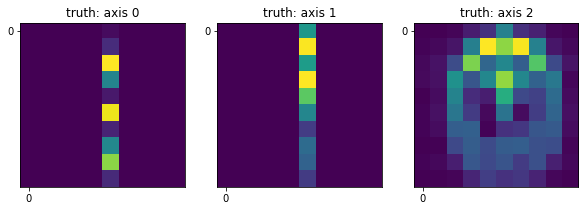

In [28]:
# view central slices
_, ax = plt.subplots(ncols=ob.ndim, figsize=(10,10))
for i in range(img.ndim):
    slice_index = img.shape[i] // 2
    ax[i].set_title('truth: axis {}'.format(i))
    ax[i].set_xticks([0, nx-1])
    ax[i].set_yticks([0, nx-1])
    ax[i].imshow(np.take(abs(img), slice_index, axis=i))